In [ ]:
pip install pymssql


In [ ]:
pip install plotly


In [ ]:
pip install seaborn


In [ ]:
pip install prophet


In [2]:
import pymssql
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go  # Import the graph objects module from Plotly
from prophet.plot import plot_plotly, plot_components_plotly

In [3]:
server = 'qaececrm-s2.database.windows.net'
database = 'QAECECRM_S2'
username = 'dbadmin'
password = 'DashTech1234'

In [4]:
conn = pymssql.connect(server=server, user=username, password=password, database=database)

In [5]:
query = """
WITH AgentArtist AS (
    SELECT 
        ap.AgentID,
        COUNT(DISTINCT bca.ArtistID) AS TotalArtistsJoined,
        COUNT(DISTINCT YEAR(ap.ReceivedDate)) AS ActiveYears
    FROM 
        AgentPayrollLog ap
    JOIN 
        Contract c ON ap.ContractID = c.ContractID
    JOIN 
        BlueCard bc ON c.BlueCardID = bc.BlueCardID
    JOIN 
        BlueCardArtist bca ON bc.BlueCardID = bca.BlueCardID
    WHERE 
        ap.ReceivedDate IS NOT NULL
    GROUP BY 
        ap.AgentID
),
Leads AS (
    SELECT 
        AgentId,
        CAST(EventDate AS DATE) AS LeadDate,
        YEAR(EventDate) AS LeadYear,
        MONTH(EventDate) AS LeadMonth,
        DAY(EventDate) AS LeadDay,
        COUNT(*) AS Leaded
    FROM (
        SELECT DISTINCT AgentId, EventDate
        FROM Lead
        WHERE EventDate IS NOT NULL
    ) deduplicated_leads
    GROUP BY AgentId, CAST(EventDate AS DATE), YEAR(EventDate), MONTH(EventDate), DAY(EventDate)
),
EventDates AS (
    SELECT 
        c.AgentID,
        CAST(bced.EventDate AS DATE) AS EventDate,
        YEAR(bced.EventDate) AS EventYear,
        MONTH(bced.EventDate) AS EventMonth,
        DAY(bced.EventDate) AS EventDay,
        COUNT(DISTINCT bced.EventDate) AS TotalEventDates
    FROM 
        BlueCardEventDate bced
    JOIN 
        BlueCard bc ON bced.BlueCardID = bc.BlueCardID
    JOIN 
        Contract c ON bc.BlueCardID = c.BlueCardID
    WHERE 
        bced.EventDate IS NOT NULL
    GROUP BY c.AgentID, CAST(bced.EventDate AS DATE), YEAR(bced.EventDate), MONTH(bced.EventDate), DAY(bced.EventDate)
)
SELECT 
    ap.AgentID,
    CAST(ap.ReceivedDate AS DATE) AS Date,  -- Include full date
    YEAR(ap.ReceivedDate) AS Year,
    MONTH(ap.ReceivedDate) AS Month,
    DAY(ap.ReceivedDate) AS Day,
    COUNT(DISTINCT bc.BlueCardID) AS TotalEventsManaged,
    COUNT(DISTINCT c.ContractID) AS TotalContractsManaged,
    SUM(ap.GrossAmount) AS TotalRevenueGenerated,
    SUM(ap.CommissionRate * ap.GrossAmount) AS TotalAgentPayments,
    MAX(ap.GrossAmount) AS HighestRevenueEvent,
    ROUND(COALESCE(aa.TotalArtistsJoined * 1.0 / NULLIF(aa.ActiveYears, 0), 0), 2) AS AvgArtistsPerYear,
    COUNT(DISTINCT c.VenuePhysicalStateId) AS TotalStatesCovered,
    COUNT(DISTINCT c.VenuePhysicalCity) AS TotalCitiesCovered,
    CASE 
        WHEN COALESCE(l.Leaded, 0) > COALESCE(ed.TotalEventDates, 0) 
        THEN COALESCE(ed.TotalEventDates, 0)
        ELSE COALESCE(l.Leaded, 0)
    END AS AdjustedLeaded
FROM 
    AgentPayrollLog ap
JOIN 
    Contract c ON ap.ContractID = c.ContractID
JOIN 
    BlueCard bc ON c.BlueCardID = bc.BlueCardID
JOIN 
    BlueCardEventDate bced ON bc.BlueCardID = bced.BlueCardID
LEFT JOIN 
    Leads l ON ap.AgentID = l.AgentId AND CAST(ap.ReceivedDate AS DATE) = l.LeadDate
LEFT JOIN 
    EventDates ed ON ap.AgentID = ed.AgentID AND CAST(ap.ReceivedDate AS DATE) = ed.EventDate
LEFT JOIN 
    AgentArtist aa ON ap.AgentID = aa.AgentID
WHERE 
    ap.ReceivedDate IS NOT NULL
    AND c.VenuePhysicalStateId IS NOT NULL
GROUP BY 
    ap.AgentID, CAST(ap.ReceivedDate AS DATE), YEAR(ap.ReceivedDate), MONTH(ap.ReceivedDate), DAY(ap.ReceivedDate), aa.TotalArtistsJoined, aa.ActiveYears, ed.TotalEventDates, l.Leaded
ORDER BY 
    ap.AgentID, Year, Month, Day;
"""

# Fetching data
AgentDataSet = pd.read_sql(query, conn)


/tmp/ipykernel_3103/2199801142.py:96: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  AgentDataSet = pd.read_sql(query, conn)


In [6]:
AgentDataSet.head(10)

,AgentID,Date,Year,Month,Day,TotalEventsManaged,TotalContractsManaged,TotalRevenueGenerated,TotalAgentPayments,HighestRevenueEvent,AvgArtistsPerYear,TotalStatesCovered,TotalCitiesCovered,AdjustedLeaded
0,104,2017-11-13,2017,11,13,1,1,1150.0,23000.0,1150.0,30.83,1,1,0
1,104,2017-11-17,2017,11,17,1,1,700.0,14000.0,700.0,30.83,1,1,0
2,104,2017-11-21,2017,11,21,1,1,1250.0,25000.0,1250.0,30.83,1,1,0
3,104,2017-12-07,2017,12,7,1,1,2250.0,56250.0,2250.0,30.83,1,1,0
4,104,2017-12-27,2017,12,27,3,3,2650.0,66250.0,1250.0,30.83,1,3,0
5,104,2018-01-03,2018,1,3,1,1,550.0,13750.0,550.0,30.83,1,1,0
6,104,2018-01-11,2018,1,11,1,1,950.0,23750.0,950.0,30.83,1,1,0
7,104,2018-01-22,2018,1,22,1,1,400.0,10000.0,400.0,30.83,1,1,0
8,104,2018-02-05,2018,2,5,2,2,2940.0,73500.0,1600.0,30.83,1,2,0
9,104,2018-02-09,2018,2,9,1,1,700.0,17500.0,700.0,30.83,1,1,0


In [7]:
df = AgentDataSet
df.describe()

,AgentID,Year,Month,Day,TotalEventsManaged,TotalContractsManaged,TotalRevenueGenerated,TotalAgentPayments,HighestRevenueEvent,AvgArtistsPerYear,TotalStatesCovered,TotalCitiesCovered,AdjustedLeaded
count,2.118800e+04,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000,2.118800e+04,21188.000000,21188.000000,21188.000000,21188.000000,21188.000000
mean,7.962962e+04,2018.766708,6.358269,15.960921,1.460497,1.511138,1981.282660,5.823487e+04,1433.737540,31.343837,1.149188,1.375165,0.033887
std,2.702644e+05,4.211173,3.367021,8.784519,0.861317,0.958781,6697.944344,1.424608e+05,1856.571529,19.406537,0.411487,0.722600,0.180943
min,1.040000e+02,2003.000000,1.000000,1.000000,1.000000,1.000000,-285123.700000,-5.702474e+06,-9310.000000,0.000000,1.000000,1.000000,0.000000
25%,2.030000e+02,2018.000000,3.000000,8.000000,1.000000,1.000000,550.000000,1.240000e+04,550.000000,17.690000,1.000000,1.000000,0.000000
50%,3.260000e+02,2020.000000,6.000000,16.000000,1.000000,1.000000,1240.000000,3.560000e+04,1100.000000,28.600000,1.000000,1.000000,0.000000
75%,4.170000e+02,2022.000000,9.000000,23.000000,2.000000,2.000000,2390.000000,7.200000e+04,1850.000000,41.430000,1.000000,2.000000,0.000000
max,1.000451e+06,2023.000000,12.000000,31.000000,13.000000,16.000000,424950.000000,8.499000e+06,80000.000000,112.000000,7.000000,12.000000,1.000000


**CHECK FOR NEGATIVE VALUES**

In [8]:
# List of columns to analyze for negative values
columns_to_check = ['TotalRevenueGenerated', 'TotalAgentPayments', 'HighestRevenueEvent']

# Calculate percentage of negative values for specified columns
negative_percentages = (df[columns_to_check] < 0).mean() * 100

# Print the results
print("Percentage of negative values in relevant columns:")
print(negative_percentages)

Percentage of negative values in relevant columns:
TotalRevenueGenerated    4.257127
TotalAgentPayments       3.888994
HighestRevenueEvent      3.204644
dtype: float64


**The percentage of negative values is less than 5%, so dropping these rows**

In [9]:
# Drop rows with negative values in the specified columns for the DataFrame named `df`
df = df[(df[['TotalRevenueGenerated', 'TotalAgentPayments', 'HighestRevenueEvent']] >= 0).all(axis=1)]


In [10]:
df.describe()

,AgentID,Year,Month,Day,TotalEventsManaged,TotalContractsManaged,TotalRevenueGenerated,TotalAgentPayments,HighestRevenueEvent,AvgArtistsPerYear,TotalStatesCovered,TotalCitiesCovered,AdjustedLeaded
count,2.026800e+04,20268.000000,20268.000000,20268.000000,20268.000000,20268.000000,20268.000000,2.026800e+04,20268.000000,20268.000000,20268.000000,20268.000000,20268.000000
mean,7.908639e+04,2018.733768,6.358101,15.957125,1.463341,1.509572,2139.387185,6.283414e+04,1507.669472,31.418787,1.150089,1.377294,0.033797
std,2.694178e+05,4.242381,3.379026,8.785088,0.855867,0.946831,6473.097628,1.370472e+05,1843.858872,19.451059,0.410153,0.718471,0.180711
min,1.040000e+02,2003.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000e+00,0.000000,0.000000,1.000000,1.000000,0.000000
25%,2.030000e+02,2018.000000,3.000000,8.000000,1.000000,1.000000,650.000000,1.520000e+04,600.000000,17.690000,1.000000,1.000000,0.000000
50%,3.260000e+02,2020.000000,6.000000,16.000000,1.000000,1.000000,1300.000000,3.800000e+04,1150.000000,28.600000,1.000000,1.000000,0.000000
75%,4.170000e+02,2022.000000,9.000000,23.000000,2.000000,2.000000,2450.000000,7.440000e+04,1890.000000,41.430000,1.000000,2.000000,0.000000
max,1.000451e+06,2023.000000,12.000000,31.000000,11.000000,16.000000,424950.000000,8.499000e+06,80000.000000,112.000000,7.000000,12.000000,1.000000


**CHECK FOR DUPLICATES**

In [11]:
# Check for duplicates
duplicates = df.duplicated()
num_duplicates = duplicates.sum()

print(f"Number of duplicate rows in the DataFrame: {num_duplicates}")

# Display duplicate rows if any
if num_duplicates > 0:
    print("\nDuplicate rows:")
    print(df[duplicates])

Number of duplicate rows in the DataFrame: 0


In [12]:
missing_data = df.isnull().sum()

# Display missing data by column
print("Missing data by column:")
print(missing_data)

Missing data by column:
AgentID                  0
Date                     0
Year                     0
Month                    0
Day                      0
TotalEventsManaged       0
TotalContractsManaged    0
TotalRevenueGenerated    0
TotalAgentPayments       0
HighestRevenueEvent      0
AvgArtistsPerYear        0
TotalStatesCovered       0
TotalCitiesCovered       0
AdjustedLeaded           0
dtype: int64


**No Missing Data**

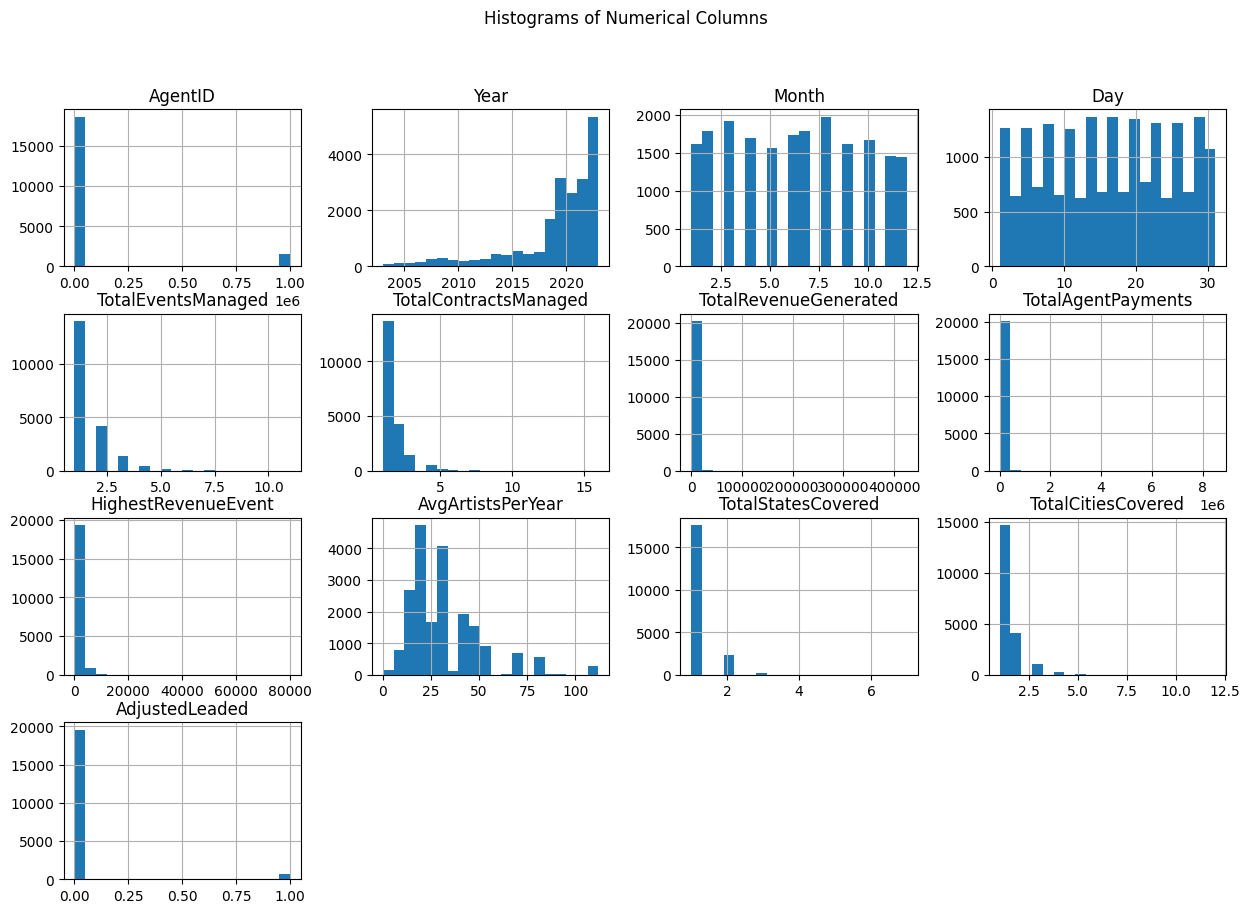

In [13]:


# Plot histograms for numerical columns
df.hist(bins=20, figsize=(15, 10))
plt.suptitle('Histograms of Numerical Columns')
plt.show()


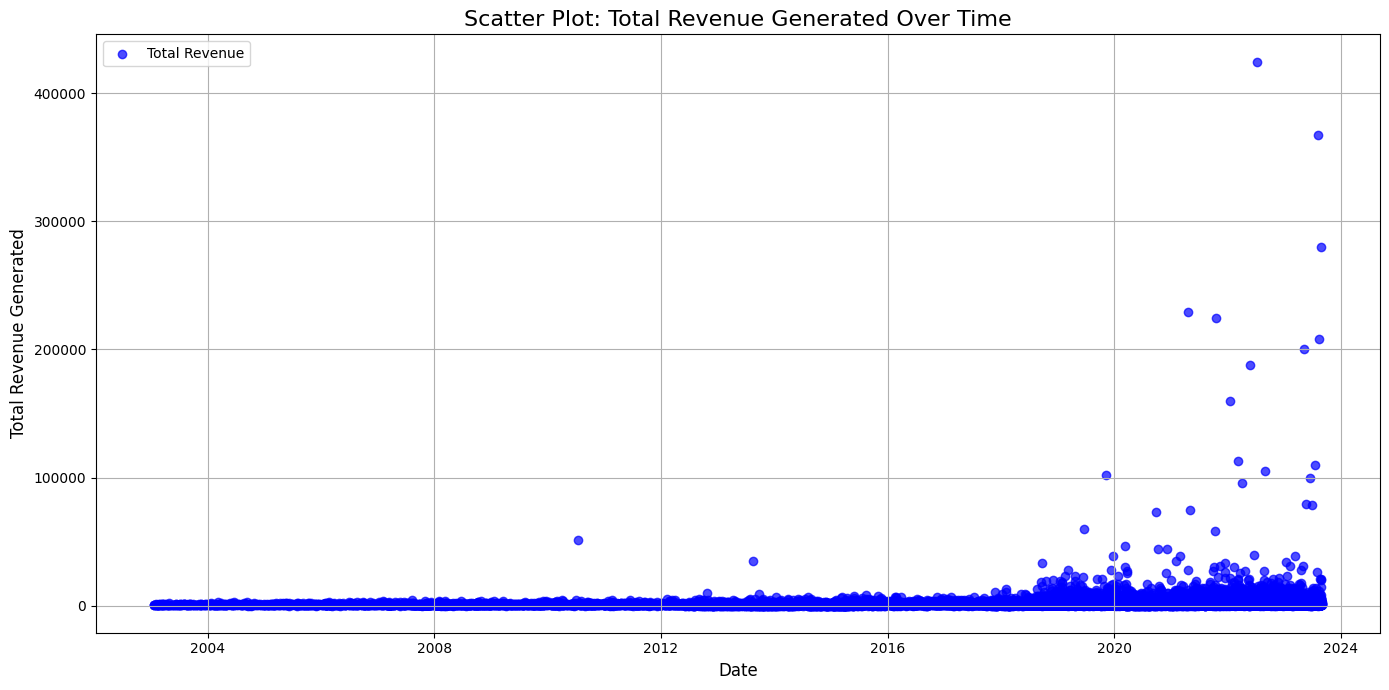

In [14]:
if 'Date' in df.columns and 'TotalRevenueGenerated' in df.columns:
    plt.figure(figsize=(14, 7))

    # Scatter plot
    plt.scatter(df['Date'], df['TotalRevenueGenerated'], alpha=0.7, color='blue', label='Total Revenue')
    plt.title('Scatter Plot: Total Revenue Generated Over Time', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Total Revenue Generated', fontsize=12)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    # Show the plot
    plt.show()
else:
    print("Required columns ('Date' and 'TotalRevenueGenerated') not found in the dataset.")


/tmp/ipykernel_3103/2454980930.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])


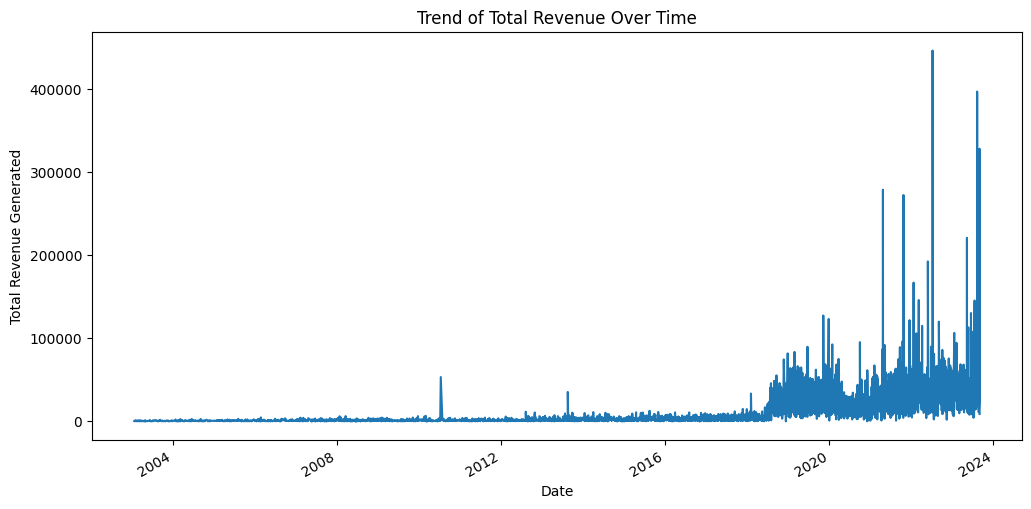

In [15]:
df['Date'] = pd.to_datetime(df['Date'])
df_aggregated = df.groupby('Date')['TotalRevenueGenerated'].sum()

# Plot the trend
plt.figure(figsize=(12, 6))
df_aggregated.plot()
plt.title('Trend of Total Revenue Over Time')
plt.xlabel('Date')
plt.ylabel('Total Revenue Generated')
plt.show()

In [17]:
# Calculate the percentage of outliers using the IQR method for each column
outlier_percentages = {}

for column in ['TotalRevenueGenerated', 'TotalAgentPayments', 'HighestRevenueEvent']:
    Q1 = df[column].quantile(0.25)  # First quartile
    Q3 = df[column].quantile(0.75)  # Third quartile
    IQR = Q3 - Q1                   # Interquartile range

    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Calculate the number of outliers
    num_outliers = ((df[column] < lower_bound) | (df[column] > upper_bound)).sum()
    percentage_outliers = (num_outliers / len(df)) * 100
    outlier_percentages[column] = percentage_outliers

outlier_percentages


{'TotalRevenueGenerated': 6.838365896980461,
 'TotalAgentPayments': 7.277481744622065,
 'HighestRevenueEvent': 5.451943951055852}

In [18]:
# List of columns to remove outliers from
columns_to_clean = ['TotalRevenueGenerated', 'TotalAgentPayments', 'HighestRevenueEvent']

# Calculate IQR and remove outliers
for column in columns_to_clean:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Remove outliers
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Display the dataset after outlier removal
print(df.shape)  # Show the new shape of the dataset

(17468, 14)


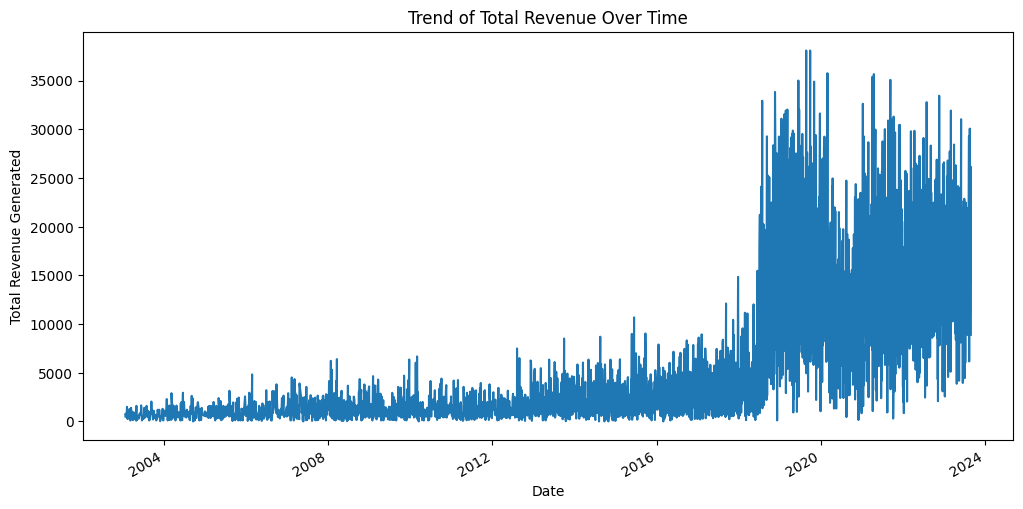

In [19]:
df['Date'] = pd.to_datetime(df['Date'])
df_aggregated = df.groupby('Date')['TotalRevenueGenerated'].sum()

# Plot the trend
plt.figure(figsize=(12, 6))
df_aggregated.plot()
plt.title('Trend of Total Revenue Over Time')
plt.xlabel('Date')
plt.ylabel('Total Revenue Generated')
plt.show()

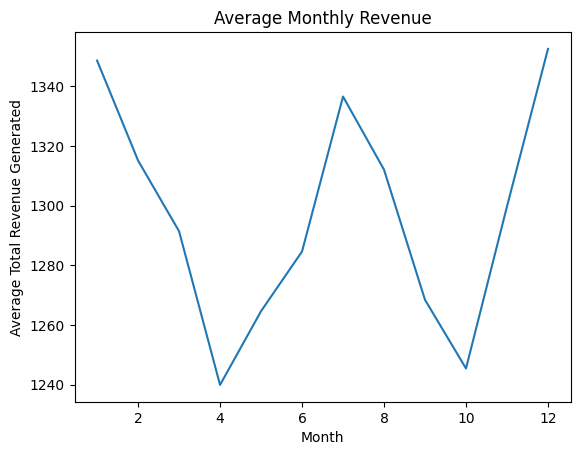

In [27]:
df['Month'] = df['Date'].dt.month
monthly_trends = df.groupby('Month')['TotalRevenueGenerated'].mean()

# Plot monthly trends
plt.plot(monthly_trends)
plt.title('Average Monthly Revenue')
plt.xlabel('Month')
plt.ylabel('Average Total Revenue Generated')
plt.show()

In [20]:
file_name = 'Cleaned_Agent_data.csv'  # Specify the file name
df.to_csv(file_name, index=False)  # Save without the index column
print(f"DataFrame saved as {file_name}")

DataFrame saved as Cleaned_Agent_data.csv


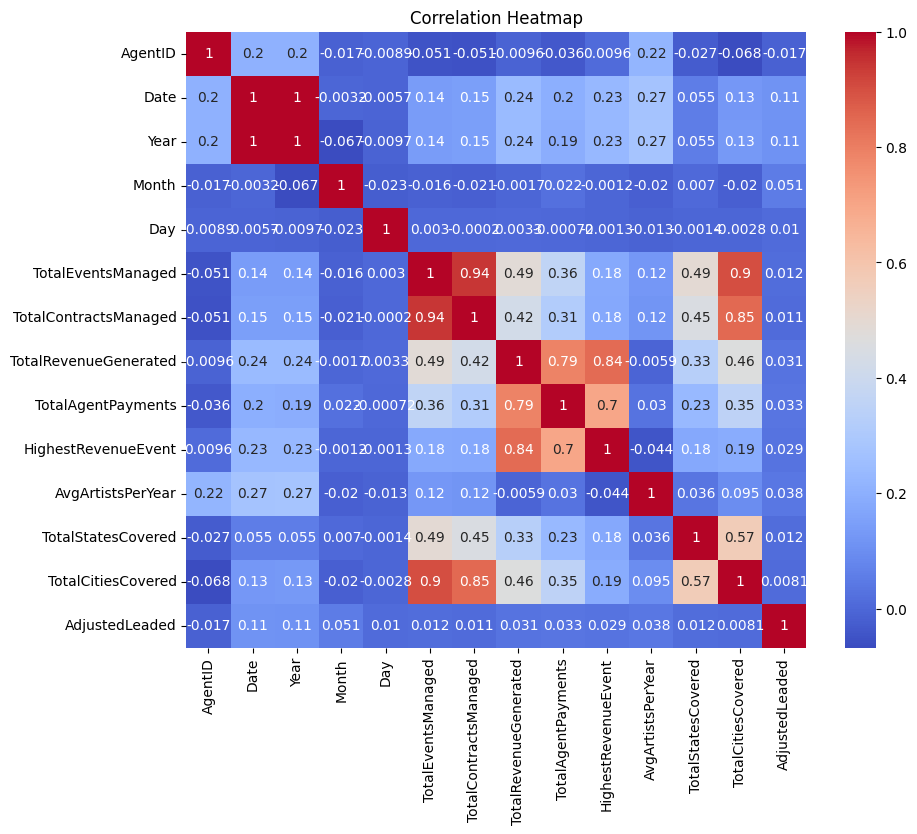

In [21]:
# Correlation heatmap
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


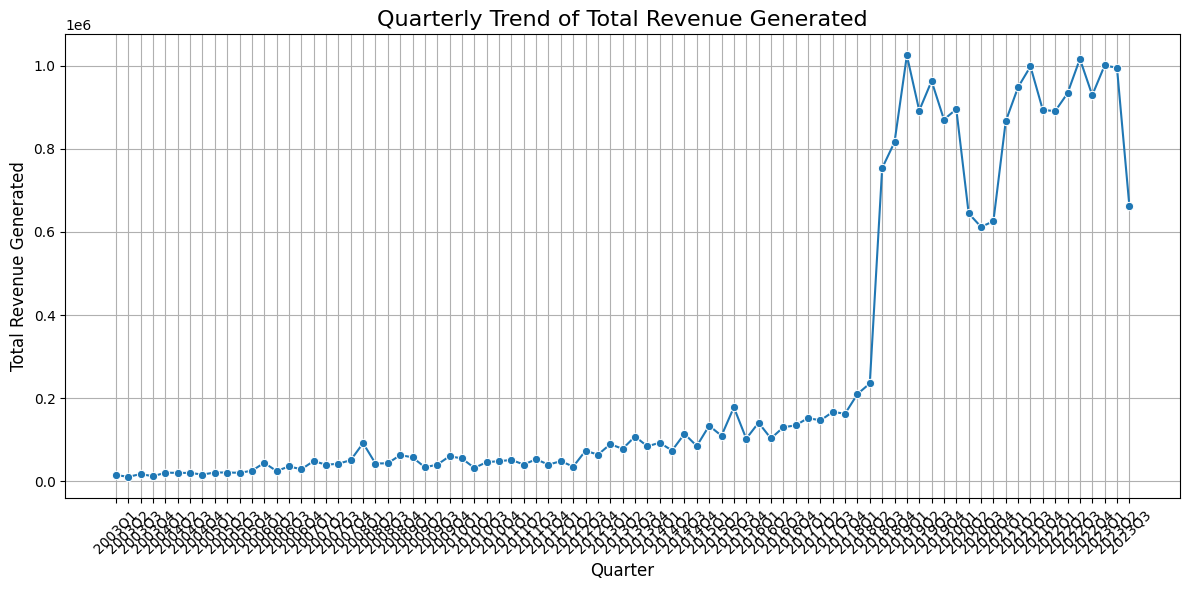

In [22]:

# Simulate data if 'df' is not defined
if 'df' not in locals():
    df = pd.DataFrame({
        'Date': pd.date_range(start='2017-01-01', periods=100, freq='D'),
        'TotalRevenueGenerated': [1000 * (1 + (i % 10 - 5) / 10) for i in range(100)]
    })

# Ensure 'Date' is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Extract quarterly information
df['Quarter'] = df['Date'].dt.to_period('Q')  # Convert to quarterly periods

# Aggregate data by quarter
quarterly_trend = df.groupby('Quarter')['TotalRevenueGenerated'].sum().reset_index()

# Convert 'Quarter' to a clean string format
quarterly_trend['Quarter'] = quarterly_trend['Quarter'].astype(str)

# Plot the quarterly trend
plt.figure(figsize=(12, 6))
sns.lineplot(x='Quarter', y='TotalRevenueGenerated', data=quarterly_trend, marker='o')
plt.title('Quarterly Trend of Total Revenue Generated', fontsize=16)
plt.xlabel('Quarter', fontsize=12)
plt.ylabel('Total Revenue Generated', fontsize=12)
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

In [23]:
# Step 1: Use the original data without applying abs() for fitting the model
prophet_data = df[['Date', 'TotalRevenueGenerated']].rename(columns={'Date': 'ds', 'TotalRevenueGenerated': 'y'})
prophet_data['ds'] = pd.to_datetime(prophet_data['ds'])  # Ensure datetime format

# Step 2: Initialize the model and fit
from prophet import Prophet

model = Prophet()
model.add_seasonality(name='quarterly', period=91.25, fourier_order=5)  # Quarterly seasonality
model.fit(prophet_data)




19:38:13 - cmdstanpy - INFO - Chain [1] start processing
19:38:15 - cmdstanpy - INFO - Chain [1] done processing


In [24]:
# Step 3: Generate future dates and make predictions
future = model.make_future_dataframe(periods=12, freq='QS')  # Forecast for 12 future quarters
forecast = model.predict(future)

# Step 4: Display the forecast
forecast_result = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
forecast_result

,ds,yhat,yhat_lower,yhat_upper
3703,2025-07-01,1737.387455,540.522242,2800.472338
3704,2025-10-01,1762.315102,600.333116,2997.899508
3705,2026-01-01,1937.249397,670.725729,3089.634990
3706,2026-04-01,1737.464632,589.464004,2931.247360
3707,2026-07-01,1819.399427,645.979857,2993.448043


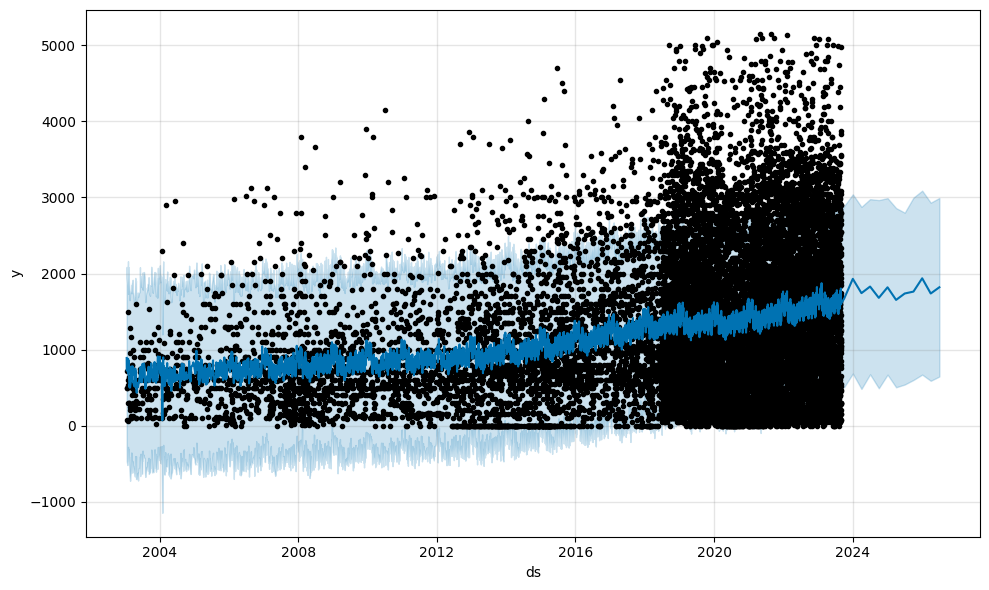

In [25]:
fig1 = model.plot(forecast)

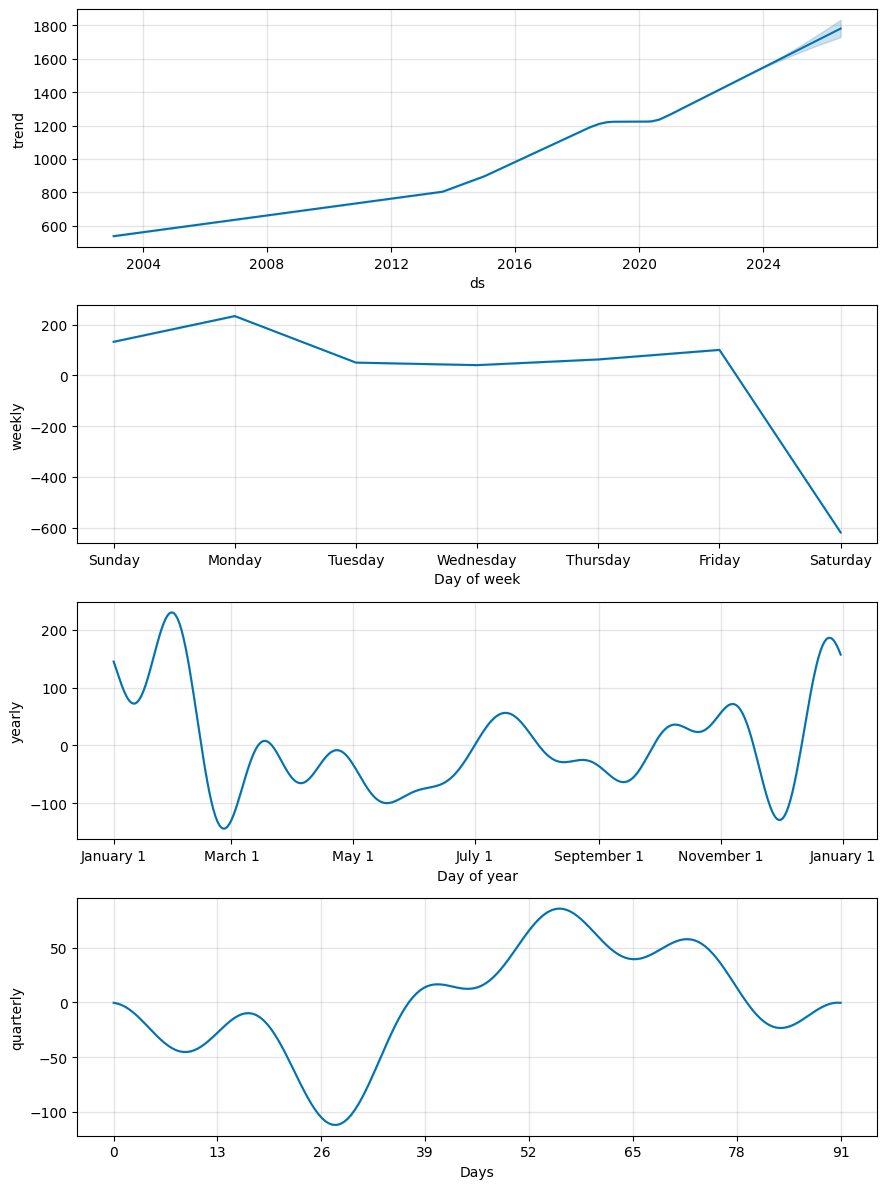

In [26]:
fig2 = model.plot_components(forecast)